# Segmentation by registration and feature extraction

In [1]:
import glob
import os
import os.path
import numpy as np
import pandas as pd
import maweight
from maweight import model_selection
from maweight.mltoolkit.automl import *
import pickle
import logging
import tqdm
from tqdm.contrib import tzip
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
import math
import matplotlib.pyplot as plt

cv = LeaveOneOut()

from numpy import mean
from numpy import absolute
from numpy import sqrt

from config import lmp_features_path, files_for_lmp_path, path_prefix_results
from config import threshold

import warnings
warnings.filterwarnings('ignore')


# setting the logging format
FORMAT = '%(asctime)-15s %(clientip)s %(user)-8s %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

Executables being used: /opt/elastix-5.1.0-linux/bin/elastix /opt/elastix-5.1.0-linux/bin/transformix


## import data as dataframe

In [2]:
data = pd.read_csv(lmp_features_path).dropna()
print(f"Sample length: {len(data)}")
cols = list(data.columns)
for c in cols:
    new_name = c.split(f'--{threshold}')[0]
    data=data.rename(columns={c: new_name})
not_targets = ["LMP", "id"]
cols = list(data.columns)
[cols.remove(t) for t in not_targets]
print(cols)
target = data["LMP"].astype(float)
features = data.drop(not_targets, axis='columns').astype(float)


Sample length: 24
['num', 'sum', 'mean', 'std', 'skew', 'kurt', 'hist-0', 'hist-1', 'hist-2', 'hist-3', 'hist-4', 'hist-5', 'hist-6', 'hist-7', 'hist-8', 'hist-9', 'hist-10', 'hist-11', 'hist-12', 'hist-13', 'hist-14', 'hist-15', 'hist-16', 'hist-17', 'hist-18', 'hist-19', 'hist-20', 'hist-21', 'hist-22', 'hist-23', 'hist-24', 'hist-25', 'hist-26', 'hist-27', 'hist-28', 'hist-29', 'hist-30', 'hist-31', 'hist-32', 'hist-33', 'hist-34', 'hist-35', 'hist-36', 'hist-37', 'hist-38', 'hist-39']


## Regression

In [3]:
def LOOCV(model, X, y):
    loo = LeaveOneOut()
    ypreds = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        model.fit(X_train, y_train)
        ypreds.append(model.predict(X_test))
    rr = r2_score(y, ypreds)
    mse = mean_squared_error(y, ypreds)
    rmse = math.sqrt(mse)
    return(rr, rmse)

## LinearRegression

LR score: 1.0
LR coef: [-7.02437917e-06  1.54002296e-08  6.15062138e-08 -2.33970268e-07
  2.45936816e-08  2.38189286e-07  1.40727424e-05 -1.45553569e-06
  2.66114306e-05  3.23845910e-05  3.59542687e-05  3.95728546e-05
  2.17650101e-05 -5.26206935e-06  3.89275150e-06 -4.28719374e-05
 -1.14699164e-04 -1.35265816e-05  2.43200581e-05 -3.17841772e-06
  9.35540284e-06 -1.34616850e-05  6.31515575e-05 -6.92909809e-05
  4.64978562e-05 -6.86977815e-05  9.85549425e-06  4.58921253e-05
  8.34827841e-05 -2.85125666e-07 -1.24183325e-05  9.98447425e-06
  1.04897841e-05  8.57695894e-06  4.22353641e-06 -2.88989230e-05
  3.11731492e-05 -8.80030196e-05  5.48858890e-05  1.98954784e-05
  2.81372491e-05 -9.34965720e-05 -1.43332329e-04 -4.24233734e-05
  8.13516789e-05  7.60317189e-05]
LR inter: 49.79438742337949
5-fold cv r2: 0.8210168680185912
5-fold cv rmse: 1.1560008725379611
loocv r2: 0.9039088806881517
loocv rmse: 0.9222596910176206


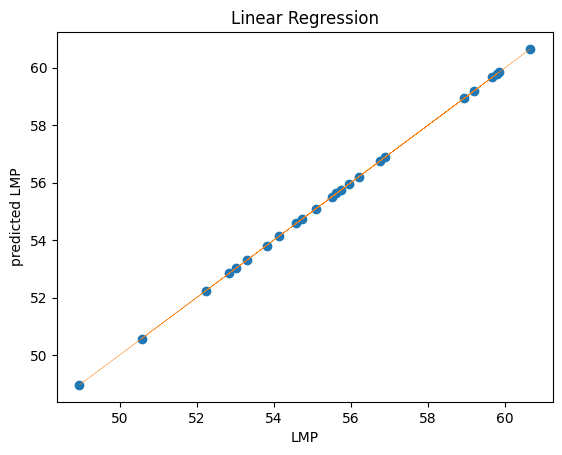

In [4]:
reg = LinearRegression().fit(features, target)
linear_score = reg.score(features, target)
linear_coef = reg.coef_
linear_inter = reg.intercept_
print(f"LR score: {linear_score}")
print(f"LR coef: {linear_coef}")
print(f"LR inter: {linear_inter}")
target_pred = reg.predict(features)
#target_pred = cross_val_predict(reg, features, target)
mse = mean_squared_error(target, target_pred)
linear_rmse = math.sqrt(mse)

model = LinearRegression()
nmse = cross_val_score(model, features, target, scoring='neg_mean_squared_error')
linear_cv_rmse = sqrt(mean(absolute(nmse)))
scores = cross_val_score(model, features, target, scoring='r2')
linear_cv_r2 = mean(scores)
#print(f"RMSE: {rmse}")
#r2 = r2_score(target, target_pred)
print(f"5-fold cv r2: {linear_cv_r2}")
print(f"5-fold cv rmse: {linear_cv_rmse}")

#loocv:
linear_loocv_r2, linear_loocv_rmse = LOOCV(model, features, target)
print(f"loocv r2: {linear_loocv_r2}")
print(f"loocv rmse: {linear_loocv_rmse}")

# plot
plt.clf()
plt.title("Linear Regression")
plt.plot(target, target_pred, 'o')
plt.xlabel('LMP')
plt.ylabel('predicted LMP')
m, b = np.polyfit(target, target_pred, 1)
plt.plot(target, m*target+b, linewidth=0.2)
plt.savefig(os.path.join(path_prefix_results, 'linear_lmp.jpg'))

### Ridge regularization

In [5]:
def regularization_ridge(features, target, alphas):

    rmse_return = None
    reg_return = None
    alpha_return = None
    r2_return = None
    for alpha in alphas:
        model = Ridge(alpha=alpha)
        reg = Ridge(alpha=alpha).fit(features, target)
        #target_pred = reg.predict(features)
        #target_pred = cross_val_predict(reg, features, target)
        #mse = mean_squared_error(target, target_pred)
        #rmse = math.sqrt(mse)
        #r2 = r2_score(target, target_pred)
        nmse = cross_val_score(model, features, target, scoring='neg_mean_squared_error')
        rmse = sqrt(mean(absolute(nmse)))
        scores = cross_val_score(model, features, target, scoring='r2')
        r2 = mean(scores)
        print(f"Ridge with alpha: {alpha}, r2: {r2}, rmse: {rmse}")
        if rmse_return:
            if rmse<rmse_return:
                rmse_return = rmse
                reg_return = reg
                alpha_return = alpha
                r2_return = r2
        else:
            rmse_return = rmse
            reg_return = reg
            alpha_return = alpha
            r2_return = r2
    return reg_return, rmse_return, r2_return, alpha_return

Ridge with alpha: 5000000000.0, r2: 0.8538321394631023, rmse: 0.9444398584705586
Ridge with alpha: 3782316637.773145, r2: 0.8629259454846006, rmse: 0.9197151559357436
Ridge with alpha: 2861183829.67511, r2: 0.8718454842384633, rmse: 0.8945601603165391
Ridge with alpha: 2164380640.5415306, r2: 0.8801843655966545, rmse: 0.8705589659528989
Ridge with alpha: 1637274581.438866, r2: 0.887581902514514, rmse: 0.8494821440710876
Ridge with alpha: 1238538177.995857, r2: 0.8937437248773712, rmse: 0.8330611666360476
Ridge with alpha: 936908711.4301934, r2: 0.8984284384205401, rmse: 0.8227828338113701
Ridge with alpha: 708737081.4634038, r2: 0.9014267902850038, rmse: 0.8196976016340337
Ridge with alpha: 536133611.00516266, r2: 0.9025637953624063, rmse: 0.8242359764502293
Ridge with alpha: 405565415.3948445, r2: 0.9017368041968403, rmse: 0.8360689277738004
Ridge with alpha: 306795363.6706582, r2: 0.898976177034544, rmse: 0.8540841031526847
Ridge with alpha: 232079441.68063864, r2: 0.8944966202458563

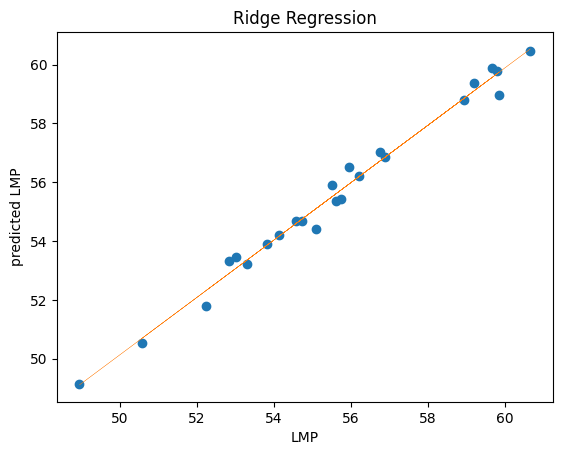

In [6]:
alphas = 10**np.linspace(10,-2,100)*0.5
reg, ridge_cv_rmse, ridge_cv_r2, alpha = regularization_ridge(features, target, alphas)
ridge_score = reg.score(features, target)
ridge_coef = reg.coef_
ridge_inter = reg.intercept_

target_pred = reg.predict(features)
#target_pred = cross_val_predict(reg, features, target)
mse = mean_squared_error(target, target_pred)
ridge_rmse = math.sqrt(mse)

print(f"Ridge score: {ridge_score}")
print(f"Ridge coef: {ridge_coef}")
print(f"Ridge inter: {ridge_inter}")
print(f"alpha: {alpha}")
print(f"5-fold cv r2: {ridge_cv_r2}")
print(f"5-fold cv rmse: {ridge_cv_rmse}")

#loocv:
model = Ridge(alpha=alpha)
ridge_loocv_r2, ridge_loocv_rmse = LOOCV(model, features, target)
print(f"loocv r2: {ridge_loocv_r2}")
print(f"loocv rmse: {ridge_loocv_rmse}")

plt.clf()
plt.title("Ridge Regression")
plt.plot(target, target_pred, 'o')
plt.xlabel('LMP')
plt.ylabel('predicted LMP')
m, b = np.polyfit(target, target_pred, 1)
plt.plot(target, m*target+b, linewidth=0.2)
plt.savefig(os.path.join(path_prefix_results, 'ridge_lmp.jpg'))

### regularization of Lasso

In [7]:
def regularization_lasso(features, target, alphas):
    rmse_return = None
    reg_return = None
    alpha_return = None
    r2_return = None
    for alpha in alphas:
        model = Lasso(alpha=alpha)
        reg = Lasso(alpha=alpha).fit(features, target)
        #target_pred = reg.predict(features)
        #target_pred = cross_val_predict(reg, features, target)
        #mse = mean_squared_error(target, target_pred)
        #rmse = math.sqrt(mse)
        #r2 = r2_score(target, target_pred)
        nmse = cross_val_score(model, features, target, scoring='neg_mean_squared_error')
        rmse = sqrt(mean(absolute(nmse)))
        scores = cross_val_score(model, features, target)
        r2 = mean(scores)
        print(f"Lasso with alpha: {alpha}, r2: {r2}, rmse: {rmse}")
        if rmse_return:
            if rmse<rmse_return:
                rmse_return = rmse
                reg_return = reg
                alpha_return = alpha
                r2_return = r2
        else:
            rmse_return = rmse
            reg_return = reg
            alpha_return = alpha
            r2_return = r2
    return reg_return, rmse_return, r2_return, alpha_return

Lasso with alpha: 5000000000.0, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 3782316637.773145, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 2861183829.67511, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 2164380640.5415306, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 1637274581.438866, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 1238538177.995857, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 936908711.4301934, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 708737081.4634038, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 536133611.00516266, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 405565415.3948445, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 306795363.6706582, r2: -0.42248018163111745, rmse: 3.1247328338094724
Lasso with alpha: 232079441.68063864

Lasso with alpha: 0.005, r2: 0.8575241650761709, rmse: 0.8948709765475671
Lasso score: 0.9997845214580947
Lasso coef: [-5.17501295e-07  1.15771319e-08  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.09478366e-05  0.00000000e+00  0.00000000e+00  1.87085532e-05
  2.47762739e-05 -7.66135830e-06 -3.75288592e-06 -1.83374567e-06
 -3.63080766e-06 -1.97743331e-06  5.34634809e-06 -1.77005518e-05
 -2.01020208e-05 -1.39843292e-05  2.22014336e-07  4.95797170e-05
  2.14252896e-05 -3.04605091e-06 -6.20740089e-06  1.46433385e-06
  4.70783867e-06  2.63256376e-06  5.15016437e-06 -1.05070562e-04
  7.68296726e-05 -1.43918019e-04  0.00000000e+00  1.86458232e-04
  1.40223422e-04 -5.06566604e-04 -0.00000000e+00  0.00000000e+00
  1.82915466e-04  0.00000000e+00]
Lasso inter: 46.62751233337664
alpha: 5.361336110051605
5-fold cv r2: 0.9695453029424875
5-fold cv rmse: 0.407767416904815
loocv r2: 

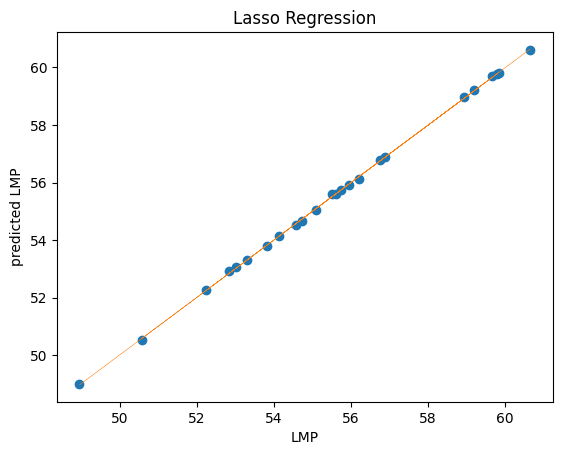

In [8]:
alphas = 10**np.linspace(10,-2,100)*0.5
reg, lasso_cv_rmse, lasso_cv_r2, alpha = regularization_lasso(features, target, alphas)
lasso_score = reg.score(features, target)
lasso_coef = reg.coef_
lasso_inter = reg.intercept_

target_pred = reg.predict(features)
#target_pred = cross_val_predict(reg, features, target)
mse = mean_squared_error(target, target_pred)
lasso_rmse = math.sqrt(mse)

print(f"Lasso score: {lasso_score}")
print(f"Lasso coef: {lasso_coef}")
print(f"Lasso inter: {lasso_inter}")
print(f"alpha: {alpha}")
print(f"5-fold cv r2: {lasso_cv_r2}")
print(f"5-fold cv rmse: {lasso_cv_rmse}")

#loocv:
model = Lasso(alpha=alpha)
lasso_loocv_r2, lasso_loocv_rmse = LOOCV(model, features, target)
print(f"loocv r2: {lasso_loocv_r2}")
print(f"loocv rmse: {lasso_loocv_rmse}")

plt.clf()
plt.title("Lasso Regression")
plt.plot(target, target_pred, 'o')
plt.xlabel('LMP')
plt.ylabel('predicted LMP')
m, b = np.polyfit(target, target_pred, 1)
plt.plot(target, m*target+b, linewidth=0.2)
plt.savefig(os.path.join(path_prefix_results,'lasso_lmp.jpg'))

### PLS regularization

In [9]:
def regularization_pls(features, target, n_components=10):
    rmse_return = None
    reg_return = None
    n_comp_return = None
    r2_return = None
    for n in n_components:
        model = PLSRegression(n_components=n)
        reg = PLSRegression(n_components=n).fit(features, target)
        #target_pred = reg.predict(features)
        #target_pred = cross_val_predict(reg, features, target)
        #mse = mean_squared_error(target, target_pred)
        #rmse = math.sqrt(mse)
        #r2 = r2_score(target, target_pred)
        nmse = cross_val_score(model, features, target, scoring='neg_mean_squared_error')
        rmse = sqrt(mean(absolute(nmse)))
        scores = cross_val_score(model, features, target)
        r2 = mean(scores)
        print(f"PLS with {n} components: r2: {r2}, rmse: {rmse}")
        if rmse_return:
            if rmse<rmse_return:
                rmse_return = rmse
                reg_return = reg
                n_comp_return = n
                r2_return = r2
        else:
            rmse_return = rmse
            reg_return = reg
            n_comp_return = n
            r2_return = r2
    return reg_return, rmse_return, r2_return, n_comp_return

In [10]:
reg, pls_cv_rmse, pls_cv_r2, n_comp = regularization_pls(features, target, np.arange(1, len(features.columns)))
pls_score = reg.score(features, target)
pls_coef = reg.coef_
pls_inter = reg.intercept_

target_pred = reg.predict(features)
target_pred = cross_val_predict(reg, features, target)
mse = mean_squared_error(target, target_pred)
pls_rmse = math.sqrt(mse)

print(f"pls score: {pls_score}")
print(f"pls coef: {pls_coef}")
print(f"pls inter: {pls_inter}")
print(f"Number of component: {n_comp}")
print(f"5-fold cv r2: {pls_cv_r2}")
print(f"5-fold cv rmse: {pls_cv_rmse}")

#loocv:
model = PLSRegression(n_components=n_comp)
pls_loocv_r2, pls_loocv_rmse = LOOCV(model, features, target)
print(f"loocv r2: {pls_loocv_r2}")
print(f"loocv rmse: {pls_loocv_rmse}")

plt.clf()
plt.title("PLS Regression")
plt.plot(target, target_pred, 'o')
plt.xlabel('LMP')
plt.ylabel('predicted LMP')
m, b = np.polyfit(target, target_pred, 1)
plt.plot(target, m*target+b, linewidth=0.2)
plt.savefig(os.path.join(path_prefix_results, 'pls_lmp.jpg'))

PLS with 1 components: r2: 0.012233576919788236, rmse: 2.0983911546846548
PLS with 2 components: r2: 0.6076070665296975, rmse: 1.6417791928218364
PLS with 3 components: r2: 0.72223779008286, rmse: 1.3928553414804263
PLS with 4 components: r2: 0.6866497161462966, rmse: 1.2779648785179065
PLS with 5 components: r2: 0.7752298597295447, rmse: 1.136600566376699
PLS with 6 components: r2: 0.7751127682486116, rmse: 1.0428887171375887
PLS with 7 components: r2: 0.7533510898121241, rmse: 1.0433764641878887
PLS with 8 components: r2: 0.7160607368024834, rmse: 1.0777897499537432
PLS with 9 components: r2: 0.7281086095641104, rmse: 1.052059613334658
PLS with 10 components: r2: 0.745841289222484, rmse: 0.9825513167237532
PLS with 11 components: r2: 0.770131474745566, rmse: 0.9254394808096545
PLS with 12 components: r2: 0.7815167631238449, rmse: 0.8879047552319368
PLS with 13 components: r2: 0.7878909524987592, rmse: 0.8677191924693848
PLS with 14 components: r2: 0.7984451161181025, rmse: 0.85941248

AttributeError: 'PLSRegression' object has no attribute 'intercept_'

## linear results

In [ ]:
lcoef = [ f"{x:.2e}" for x in linear_coef]
eq = " + ".join([f"{i}*{j}" for i, j in zip(cols, lcoef)])
print(f"Equation of linear regression: LMP = {eq} + {linear_inter}")
print(f"r2: {linear_score}")
print(f"rmse: {linear_rmse}")
print(f"5-fold cv r2: {linear_cv_r2}")
print(f"5-fold cv rmse: {linear_cv_rmse}")
print(f"loocv r2: {linear_loocv_r2}")
print(f"loocv rmse: {linear_loocv_rmse}")

## Ridge results

In [ ]:
rcoef = [ f"{x:.2e}" for x in ridge_coef]
eq = " + ".join([f"{i}*{j}" for i, j in zip(cols, rcoef)])
print(f"Equation of ridge regression: LMP = {eq} + {ridge_inter}")
print(f"r2: {ridge_score}")
print(f"rmse: {ridge_rmse}")
print(f"5-fold cv r2: {ridge_cv_r2}")
print(f"5-fold cv rmse: {ridge_cv_rmse}")
print(f"loocv r2: {ridge_loocv_r2}")
print(f"loocv rmse: {ridge_loocv_rmse}")

## Lasso results

In [ ]:
lcoef = [ f"{x:.2e}" for x in lasso_coef]
eq = " + ".join([f"{i}*{j}" for i, j in zip(cols, lcoef)])
print(f"Equation of lasso regression: LMP = {eq} + {lasso_inter}")
print(f"r2: {lasso_score}")
print(f"rmse: {lasso_rmse}")
print(f"5-fold cv r2: {lasso_cv_r2}")
print(f"5-fold cv rmse: {lasso_cv_rmse}")
print(f"loocv r2: {lasso_loocv_r2}")
print(f"loocv rmse: {lasso_loocv_rmse}")  

## PLS results

In [ ]:
print(pls_coef)
print(len(pls_coef))
print(f"r2: {pls_score}")
print(f"rmse: {pls_rmse}")
print(f"5-fold cv r2: {pls_cv_r2}")
print(f"5-fold cv rmse: {pls_cv_rmse}")
print(f"loocv r2: {pls_loocv_r2}")
print(f"loocv rmse: {pls_loocv_rmse}")

In [ ]:
print(len(features))
print(1/5)
print(int(24/5))
print(24*0.2)
print(24*0.8)
from sklearn.model_selection import KFold
kf = KFold()
for i, (train_index, test_index) in enumerate(kf.split(features)):
    print(f"train: {len(train_index)} test: {len(test_index)}")
    